# Fish disease diagnosis with MobileNet

## Setting up

In [ ]:
%pip install tensorflow==2.16.0rc0 matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, whic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, callbacks, losses, optimizers, metrics
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import backend as K
from tensorflow.keras.saving import save_model, load_model
import seaborn as sns
from sklearn import metrics

## Configuration the parameters

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2

## Loading and pre-processing dataset

In [ ]:
train_ds_path = '/kaggle/input/fishasd/SalmonScan-split/train'
val_ds_path = '/kaggle/input/fishasd/SalmonScan-split/val'
test_ds_path = '/kaggle/input/fishasd/SalmonScan-split/test'

In [ ]:
train_ds = image_dataset_from_directory(
    train_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=True,
    interpolation="bilinear",
    data_format='channels_last',
)

val_ds = image_dataset_from_directory(
    val_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=True,
    interpolation="bilinear",
    data_format='channels_last',
)

test_ds = image_dataset_from_directory(
    test_ds_path,
    label_mode="int",
    color_mode="rgb",
    image_size=(input_shape[0], input_shape[1]),
    shuffle=False,
    interpolation="bilinear",
    data_format='channels_last',
)

Found 724 files belonging to 2 classes.
Found 241 files belonging to 2 classes.
Found 243 files belonging to 2 classes.


In [ ]:
data_preprocessing = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name="data_preprocessing",
)

# Compute the mean and the variance of the training data for normalization.
unbatch_train_ds = train_ds.unbatch()
feature_ds = unbatch_train_ds.map(lambda x, y: x)
data_preprocessing.layers[0].adapt(feature_ds)

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

## The MobileNet Model

In [ ]:
def create_mobilenet_classifier(optimizer, learning_rate, drop_out, weight_decay):
  # Load a pre-trained model
  pretrained_model = tf.keras.applications.MobileNet(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet"
  )

  # Implement transfer learning
  pretrained_model.trainable = False

  model = Sequential([
      data_preprocessing,
#       data_augmentation,
      pretrained_model,
      layers.GlobalAveragePooling2D(keepdims=True),
      layers.Dropout(drop_out, name='dropout'),
      layers.Conv2D(2, (1, 1), padding='same'),
      layers.Reshape((2,), name='reshape_2'),
      layers.Activation(activation='softmax')
  ])

  optimizer = optimizers.get(optimizer)
  optimizer.learning_rate = learning_rate
  optimizer.weight_decay = weight_decay

  loss = losses.SparseCategoricalCrossentropy()

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model

## Hyperparameters tuning

In [ ]:
num_epochs = 1000

# configure test hyperparameters
tune_optimizers = ['rmsprop', 'adam', 'sgd']
tune_learning_rates = [0.001 ,0.01, 0.0001, 0.00001]
tune_dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
tune_weight_decays = [0.0001, 0.001, 0.00001, 0.000001]
tune_batch_sizes = [32, 16, 64, 128]

In [ ]:
best_optimizer = tune_optimizers[0]
best_learning_rate = tune_learning_rates[0]
best_drop_out = tune_dropouts[0]
best_batch_size = tune_batch_sizes[0]
best_weight_decay = tune_weight_decays[0]

In [ ]:
def run_hyperparameters_tuning(optimizer=tune_optimizers[0], learning_rate=tune_learning_rates[0], dropout=tune_dropouts[0], batch_size=tune_batch_sizes[0], weight_decay=tune_weight_decays[0]):
  model = create_mobilenet_classifier(optimizer, learning_rate, dropout, weight_decay)

  train_ds.batch_size = batch_size
  val_ds.batch_size = batch_size
  test_ds.batch_size = batch_size

  history = model.fit(
      train_ds,
      epochs=num_epochs,
      verbose=0,
      callbacks=callbacks.EarlyStopping(
          monitor="val_loss", min_delta=0, patience=5, verbose=1,
          baseline=True, restore_best_weights=True, start_from_epoch=10
      ),
      validation_data=val_ds,
      shuffle=False,
  )

  metric_results = model.evaluate(val_ds, return_dict=True)

  return metric_results['accuracy']

In [ ]:
print(f'Start hyperparameters tuning.............')

# Tuning optimizer
print('Tuning parameter: optimizer')
best_mean = 0
for optimizer in tune_optimizers:
  print(f'parameter: {optimizer}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=optimizer)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)

  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_optimizer = optimizer

  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best optimizer: {best_optimizer}')
print('\n')

# Tuning learning rate
print('Tuning parameter: learning rate')
best_mean = 0
for learning_rate in tune_learning_rates:
  print(f'parameter: {learning_rate}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=learning_rate)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)

  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_learning_rate = learning_rate

  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best learning rate: {best_learning_rate}')
print('\n')

# Tuning dropout
print('Tuning parameter: dropout')
best_mean = 0
for dropout in tune_dropouts:
  print(f'parameter: {dropout}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=dropout)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)

  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_dropout = dropout

  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best dropout: {best_dropout}')
print('\n')

# Tuning weight decay
print('Tuning parameter: weight decay')
best_mean = 0
for weight_decay in tune_weight_decays:
  print(f'parameter: {weight_decay}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=best_dropout, weight_decay=weight_decay)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)

  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_weight_decay = weight_decay

  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best weight decay: {best_weight_decay}')
print('\n')

# Tuning batch size
print('Tuning parameter: batch size')
best_mean = 0
for batch_size in tune_batch_sizes:
  print(f'parameter: {batch_size}')
  accuracies = np.array([])

  for i in range(5):
    accuracy = run_hyperparameters_tuning(optimizer=best_optimizer, learning_rate=best_learning_rate, dropout=best_dropout, weight_decay=best_weight_decay, batch_size=batch_size)
    print(f'loop {i} accuracy {accuracy}')
    accuracies = np.concatenate((accuracies, [accuracy]),axis=0)

  mean = np.mean(accuracies)
  std = np.std(accuracies)

  if mean > best_mean:
    best_mean = mean
    best_batch_size = batch_size

  print(f'mean: {mean}')
  print(f'std: {std}')
  print('-----------------------------------------------------')
print(f'Best batch size: {best_batch_size}')
print('\n')

Start hyperparameters tuning.............
Tuning parameter: optimizer
parameter: rmsprop
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1710649232.599720     114 service.cc:145] XLA service 0x7d5988002400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710649232.601016     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1710649237.485403     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9741 - loss: 0.0953
loop 0 accuracy 0.9626556038856506
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9718 - loss: 0.1111
loop 1 accuracy 0.9709543585777283
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9644 - loss: 0.1109
loop 2 accuracy 0.9626556038856506
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9759 - loss: 0.0822
loop 3 accuracy 0.9668049812316895
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9743 - loss: 0.0921
loop 4 accuracy 0.9751037359237671
mean: 0.9676348567008972
std: 0.00483896

## Compile, train and evaluate the model with best hyperparameters

In [ ]:
!rm -r logs
!mkdir logs

In [ ]:
csv_logger_filepath = 'logs/result.csv'
save_model_filpath = 'logs/mobilenet.keras'

In [ ]:
# Call back
csv_logger = callbacks.CSVLogger(
    csv_logger_filepath,
    separator=",",
    append=True
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=True,
    restore_best_weights=True,
    start_from_epoch=10,
)

def run_experiment(model, batch_size, num_epochs):

    train_ds.batch_size = batch_size
    val_ds.batch_size = batch_size
    test_ds.batch_size = batch_size

    history = model.fit(
        train_ds,
        epochs=num_epochs,
        callbacks=[
            csv_logger, early_stopping
        ],
        validation_data=val_ds,
        shuffle=False,
    )

    save_model(model, save_model_filpath, overwrite=True)

    # Evaluate the model
    metric_results = model.evaluate(test_ds, return_dict=True )
    print(f"Test accuracy: {round(metric_results['accuracy'] * 100, 2)}%")


    return history, model

In [ ]:
print(best_learning_rate)
print(best_optimizer)
print(best_dropout)
print(best_batch_size)
print(best_weight_decay)

0.01
adam
0.2
64
1e-05


In [ ]:
model = create_mobilenet_classifier(best_optimizer,best_learning_rate, best_dropout, best_weight_decay)
history, model = run_experiment(model, best_batch_size, num_epochs)

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - accuracy: 0.5846 - loss: 2.3276 - val_accuracy: 0.7261 - val_loss: 0.7026
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8144 - loss: 0.5746 - val_accuracy: 0.9544 - val_loss: 0.1942
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9341 - loss: 0.1983 - val_accuracy: 0.9627 - val_loss: 0.1258
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9592 - loss: 0.1232 - val_accuracy: 0.9627 - val_loss: 0.0952
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9593 - loss: 0.1018 - val_accuracy: 0.9585 - val_loss: 0.1291
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9590 - loss: 0.1112 - val_accuracy: 0.9668 - val_loss: 0.0932
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9699 - loss: 0.0667 - val_accuracy: 0.9544 - val_loss: 0.1731
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9555 - loss: 0.1046 - val_ac

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

unbatch_test_ds = test_ds.unbatch()
true_labels = list(unbatch_test_ds.map(lambda x, y: y))
predicted_labels = model.predict(test_ds).argmax(axis=-1)

print(predicted_labels)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


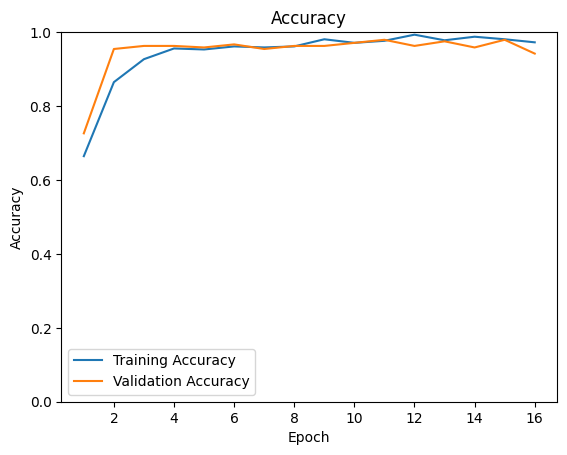

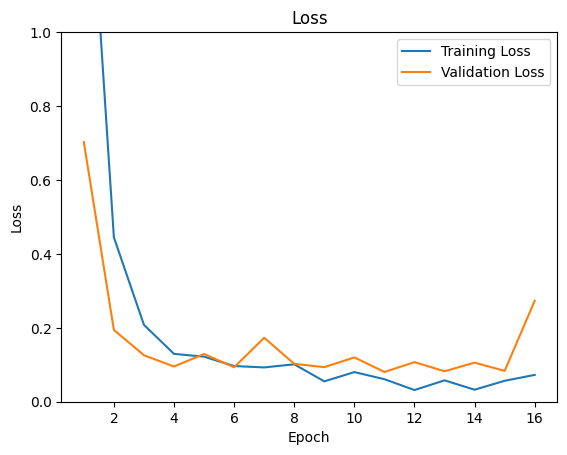

              precision    recall  f1-score   support

           0     0.9880    0.8913    0.9371        92
           1     0.9375    0.9934    0.9646       151

    accuracy                         0.9547       243
   macro avg     0.9627    0.9423    0.9509       243
weighted avg     0.9566    0.9547    0.9542       243



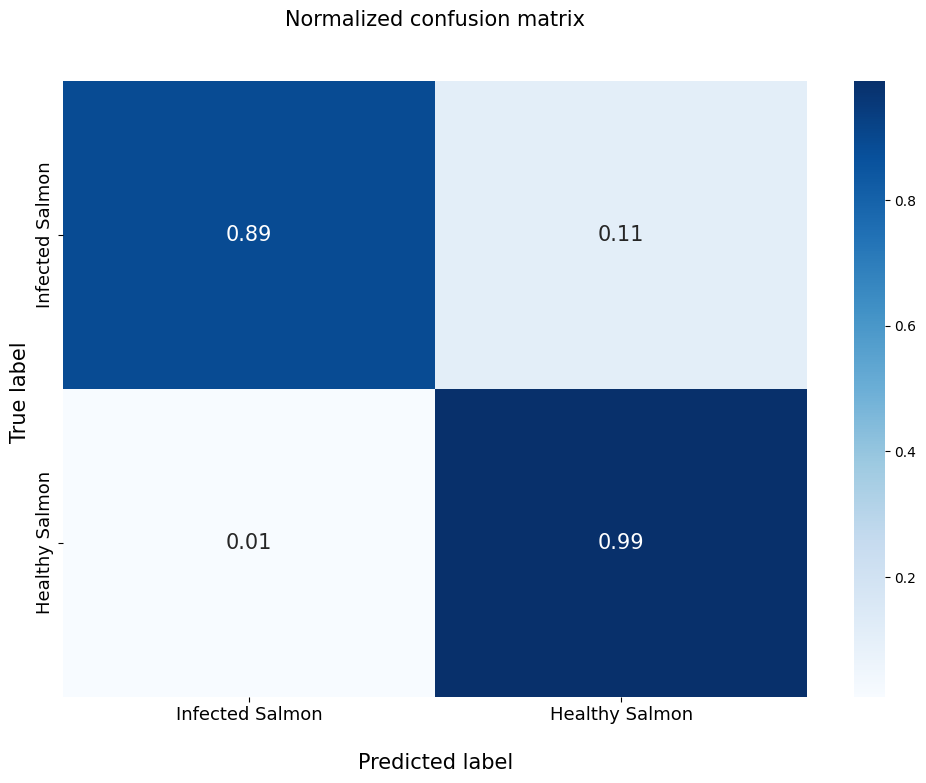

In [ ]:
plt.axis(ymin=0.0, ymax=1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('logs/accuracy.png')
plt.show()

plt.axis(ymin=0.0, ymax=1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('logs/loss.png')
plt.show()

report = metrics.classification_report(true_labels,predicted_labels, digits=4)
print(report)

cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy()
ncm = np.round(cm/np.sum(cm, axis=1).reshape(-1,1),2)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(ncm, annot=True, cmap='Blues', fmt='g', annot_kws={"size":15})
ax.set_title('Normalized confusion matrix\n\n', fontsize=15);
ax.set_xlabel('\nPredicted label', fontsize=15)
ax.set_ylabel('True label ', fontsize=15);
ax.xaxis.set_ticklabels(['Infected Salmon','Healthy Salmon'], fontsize=13)
ax.yaxis.set_ticklabels(['Infected Salmon','Healthy Salmon'], fontsize=13)
plt.savefig('logs/normalized_confusion_atrix.png')
plt.show()

In [ ]:
!rm -f logs.zip
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/accuracy.png (deflated 11%)
  adding: logs/loss.png (deflated 8%)
  adding: logs/normalized_confusion_atrix.png (deflated 18%)
  adding: logs/mobilenet.keras (deflated 9%)
  adding: logs/result.csv (deflated 54%)


In [ ]:
model.summary()

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_preprocessing (Sequential) │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_113    │ (None, 1, 1, 1024)     │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 1, 1, 2)        │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_113 (Activation)     │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,023 (12.34 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 3,228,871 (12.32 MB)

 Optimizer params: 4,102 (16.03 KB)